In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
import time

from ctisim.utils import ITL_AMP_GEOM
from ctisim.image import SegmentSimulator
from ctisim.core import LinearTrap, LogisticTrap, FloatingOutputAmplifier, BaseOutputAmplifier
from ctisim.matrix import cti_operator

In [2]:
def trap_operator_old(pixel_signals, trapsize1, scaling, trapsize2, f0, k):

    def f(pixel_signals):

        return np.minimum(trapsize1, pixel_signals*scaling) + trapsize2/(1.+np.exp(-k*(pixel_signals-f0)))
    
    S_estimate = pixel_signals + f(pixel_signals)

    C = f(S_estimate)
    R = np.zeros(C.shape)
    R[:, 1:] += f(S_estimate)[:, :-1]
    T = R - C   
    
    return T

def trap_operator_new(pixel_signals, trapsize1, scaling, trapsize2, f0, k, tau):
    
    def f(pixel_signals):

        return np.minimum(trapsize1, pixel_signals*scaling) + trapsize2/(1.+np.exp(-k*(pixel_signals-f0)))
    
    r = np.exp(-1/tau)
    S_estimate = pixel_signals + f(pixel_signals)
    
    C = f(S_estimate)
    C = np.maximum(0, C)
    R = np.zeros(C.shape)
    R[:, 1:] = f(S_estimate)[:,:-1]*(1-r)
    R[:, 2:] += np.maximum(0, (f(S_estimate[:, :-2])-f(S_estimate[:, 1:-1]))*r*(1-r))
    T = R - C
    
    return T

## Testing on Simulations

In [13]:
cti = 1.E-6
tau = 0.4

output_amplifier = BaseOutputAmplifier(1.0, noise=6.5/np.sqrt(2000.))
#output_amplifier = FloatingOutputAmplifier(1.0, 0.0002289994239807129, 2.434251, noise=6.5/np.sqrt(2000.))

trapsize1 = 4.0
scaling = 0.08
trapsize2 = 40.0
f0 = 17500.
k = 0.001

num_signals = 200
trap1 = LinearTrap(trapsize1, tau, 1, scaling)
trap2 = LogisticTrap(trapsize2, tau, 1, f0, k)
signals = np.logspace(2, np.log10(175000.), num_signals)

imarr = np.zeros((num_signals, ITL_AMP_GEOM.nx))
segment = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, traps=[trap1, trap2])
segment.ramp_exp(signals)

segarr = segment.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, parallel_overscan_width=0)

ny, nx = segarr.shape

Text(0.5, 1.0, 'Simulation: Run3')

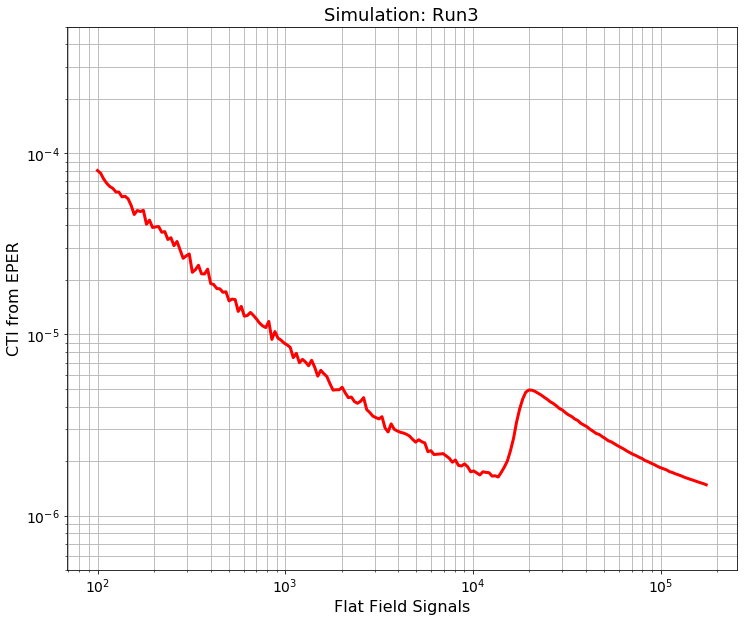

In [14]:
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
lastpix = segarr[:, 511]
cti_results = (oscan1+oscan2)/(lastpix*512)

fig, ax =plt.subplots(1, 1, figsize=(12, 10))
ax.plot(signals, cti_results, linewidth=3, color='red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(5.E-7, 5.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('CTI from EPER', fontsize=16)
ax.set_xlabel('Flat Field Signals', fontsize=16)
ax.grid(which='both', axis='both')
ax.set_title('Simulation: Run3', fontsize=18)

In [15]:
D_cti = cti_operator(cti, segarr.shape[1])
Dinv_cti = inv(D_cti)

corrected_old = np.zeros(segarr.shape)
corrected_new = np.zeros(segarr.shape)

## Old Version
T = trap_operator_old(segarr, trapsize1, scaling, trapsize2, f0, k)   
S = segarr - (1-cti)*T
for i in range(segarr.shape[0]):
    
    corrected_old[i, :] = Dinv_cti*S[i, :]

## New Version
T = trap_operator_new(segarr, trapsize1, scaling, trapsize2, f0, k, tau)
S = segarr - (1-cti)*T
for i in range(segarr.shape[0]):
    
    corrected_new[i, :] = Dinv_cti*S[i, :]

/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


Text(0.5, 1.0, 'New Correction')

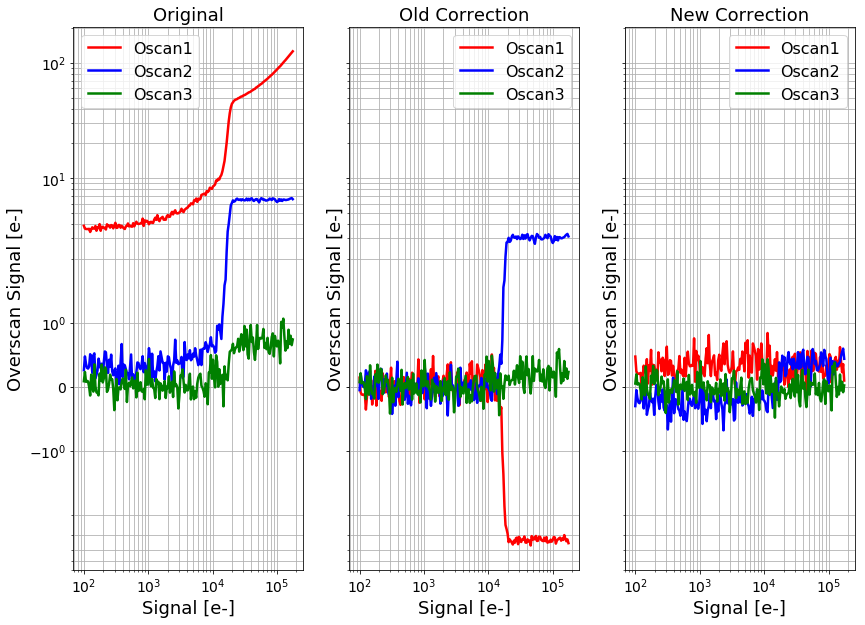

In [16]:
## Data
oscan1_data = segarr[:, 512]
oscan2_data = segarr[:, 513]
oscan3_data = segarr[:, 514]

## Corrected
oscan1_corrected_old = corrected_old[:, 512]
oscan2_corrected_old = corrected_old[:, 513]
oscan3_corrected_old = corrected_old[:, 514]

oscan1_corrected_new = corrected_new[:, 512]
oscan2_corrected_new = corrected_new[:, 513]
oscan3_corrected_new = corrected_new[:, 514]

fig, axes = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
    
axes[0].plot(signals, oscan1_data, linewidth=2.5, color='red', label='Oscan1')
axes[0].plot(signals, oscan2_data, linewidth=2.5, color='blue', label='Oscan2')
axes[0].plot(signals, oscan3_data, linewidth=2.5, color='green', label='Oscan3')
#ax.set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_yscale('symlog', subsy=[2, 3, 4, 5, 6, 7, 8, 9])
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(which='both')
axes[0].legend(fontsize=16)
axes[0].set_xlabel('Signal [e-]', fontsize=18)
axes[0].set_ylabel('Overscan Signal [e-]', fontsize=18)
axes[0].set_title('Original', fontsize=18)

axes[1].plot(signals, oscan1_corrected_old, linewidth=2.5, color='red', label='Oscan1')
axes[1].plot(signals, oscan2_corrected_old, linewidth=2.5, color='blue', label='Oscan2')
axes[1].plot(signals, oscan3_corrected_old, linewidth=2.5, color='green', label='Oscan3')
#ax.set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('symlog', subsy=[2, 3, 4, 5, 6, 7, 8, 9])
axes[1].legend(fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(which='both')
axes[1].set_xlabel('Signal [e-]', fontsize=18)
axes[1].set_ylabel('Overscan Signal [e-]', fontsize=18)
axes[1].set_title('Old Correction', fontsize=18)

axes[2].plot(signals, oscan1_corrected_new, linewidth=2.5, color='red', label='Oscan1')
axes[2].plot(signals, oscan2_corrected_new, linewidth=2.5, color='blue', label='Oscan2')
axes[2].plot(signals, oscan3_corrected_new, linewidth=2.5, color='green', label='Oscan3')
#ax.set_yscale('log')
axes[2].set_xscale('log')
axes[2].set_yscale('symlog', subsy=[2, 3, 4, 5, 6, 7, 8, 9])
axes[2].legend(fontsize=16)
axes[2].tick_params(axis='both', which='major', labelsize=14)
axes[2].grid(which='both')
axes[2].set_xlabel('Signal [e-]', fontsize=18)
axes[2].set_ylabel('Overscan Signal [e-]', fontsize=18)
axes[2].set_title('New Correction', fontsize=18)

Text(0.5, 0, 'Signal [e-]')

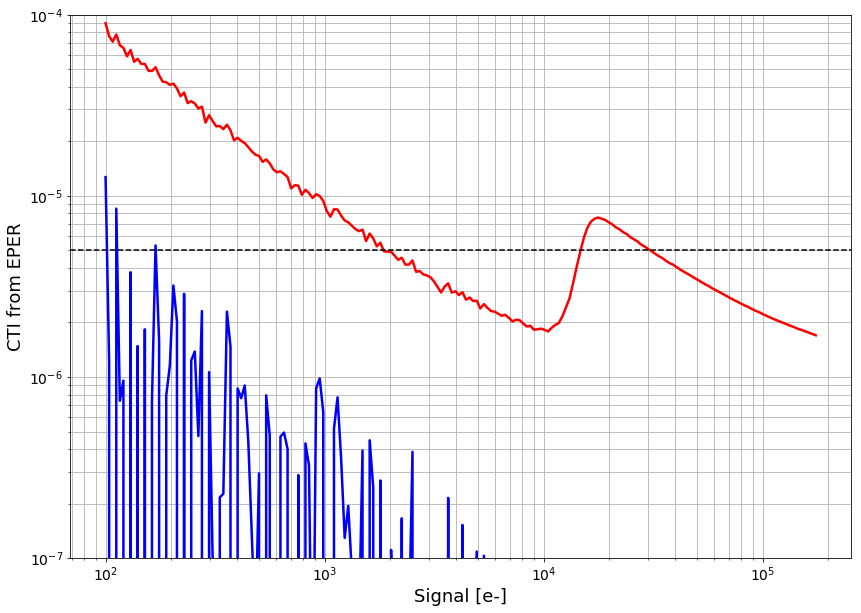

In [143]:
## Data
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_data = ((oscan1+oscan2)/(512*last_pix))

## Corrected
last_pix = corrected_new[:, 511]
oscan1 = corrected_new[:, 512]
oscan2 = corrected_new[:, 513]
cti_corrected_new = ((oscan1+oscan2)/(512*last_pix))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
ax.plot(signals, cti_data, linewidth=2.5, color='red')
ax.plot(signals, cti_corrected_new, linewidth=2.5, color='blue')
ax.axhline(y=5.E-6, color='black', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

In [138]:
print(cti_corrected_new)

[-2.20898727e-06  8.34994738e-06 -6.41578490e-06  7.93380248e-06
  3.03749534e-07  1.95905722e-06 -2.63803093e-06 -5.06864257e-06
  2.91827692e-06  2.80949749e-06  1.20636808e-06 -1.64801335e-06
  1.40093420e-07  1.44616479e-06  3.40335188e-06  3.40661120e-06
  5.57854351e-06  1.60813979e-06 -2.54473096e-06  4.73554542e-06
  1.51274973e-07  3.17386779e-06 -9.61788704e-07 -1.20146565e-06
  2.64320486e-07 -9.15066858e-07  1.62283487e-07  1.64232924e-06
  1.33643827e-06  5.39239747e-07  1.52034783e-06 -1.68499695e-06
 -4.48747453e-07 -7.05570981e-07  1.24901397e-06  2.04372238e-06
 -4.74378684e-08  8.34297582e-07  2.94907321e-07 -1.30763590e-06
  3.87372629e-07 -4.61640152e-07  1.03842392e-06  1.30398374e-06
 -6.46352678e-07  1.40658069e-06 -2.28912262e-07  4.69526292e-08
 -3.39396365e-07  1.40962729e-06  1.53301778e-07 -5.31566546e-07
  5.90187221e-07 -3.72774140e-07 -1.59735174e-07  4.62355429e-07
  6.61541492e-07  2.86825006e-08 -9.03248327e-08  3.23563855e-07
  2.72471936e-07  4.10483

## Testing on Real Data

0.05617523193359375


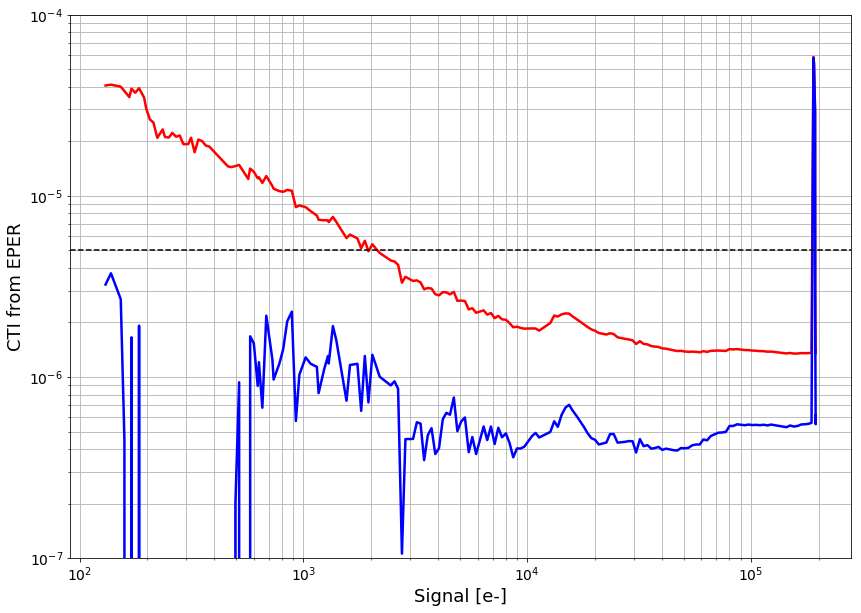

In [6]:
amp = 9

## Get data for comparison
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

data = hdul[amp].data
segarr = data['COLUMN_MEAN']
signals = data['FLATFIELD_SIGNAL']

## Correct with matrix
D_cti = cti_operator(7.390348241862516e-07, nx)
Dinv_cti = inv(D_cti)

corrected = np.zeros(segarr.shape)
#T = one_trap_operator(segarr, 3.461589243866243, 0.018437923800313328)
T = two_trap_operator(segarr, 3.461589243866243, 0.018437923800313328, 
                      2.809391017193702, 12604.767814155908, 0.003718244516148498)
#T = np.zeros(segarr.shape)
S = segarr - (1-cti)*T

start = time.time()
start = time.time()
for i in range(segarr.shape[0]):
    
    corrected[i, :] = Dinv_cti*S[i, :]
    
stop = time.time()
print(stop-start)

## Data
last_pix = data['COLUMN_MEAN'][:, 511]
oscan1 = data['COLUMN_MEAN'][:, 512]
oscan2 = data['COLUMN_MEAN'][:, 513]
cti_data = ((oscan1+oscan2)/(512*last_pix))

## Corrected
last_pix = corrected[:, 511]
oscan1 = corrected[:, 512]
oscan2 = corrected[:, 513]
cti_corrected = ((oscan1+oscan2)/(512*last_pix))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
ax.plot(signals, cti_data, linewidth=2.5, color='red')
ax.plot(signals, cti_corrected, linewidth=2.5, color='blue')
ax.axhline(y=5.E-6, color='black', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)
plt.savefig('correction_test_data.png')

Text(0, 0.5, 'Overscan Signal [e-]')

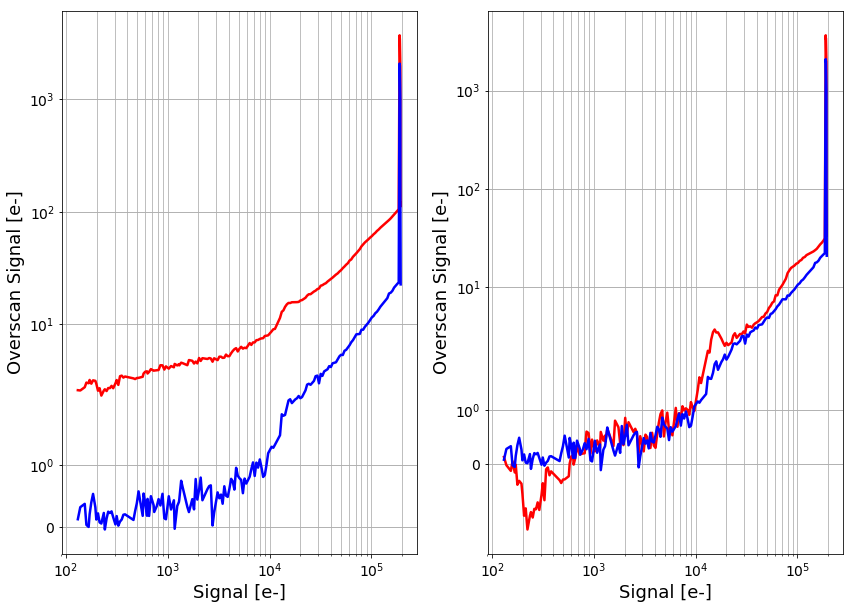

In [15]:
## Data
oscan1_data = data['COLUMN_MEAN'][:, 512]
oscan2_data = data['COLUMN_MEAN'][:, 513]

## Corrected
oscan1_corrected = corrected[:, 512]
oscan2_corrected = corrected[:, 513]

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
    
axes[0].plot(signals, oscan1_data, linewidth=2.5, color='red')
axes[0].plot(signals, oscan2_data, linewidth=2.5, color='blue')
#ax.set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_yscale('symlog')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(which='both')
axes[0].set_xlabel('Signal [e-]', fontsize=18)
axes[0].set_ylabel('Overscan Signal [e-]', fontsize=18)

axes[1].plot(signals, oscan1_corrected, linewidth=2.5, color='red')
axes[1].plot(signals, oscan2_corrected, linewidth=2.5, color='blue')
#ax.set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('symlog')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(which='both')
axes[1].set_xlabel('Signal [e-]', fontsize=18)
axes[1].set_ylabel('Overscan Signal [e-]', fontsize=18)

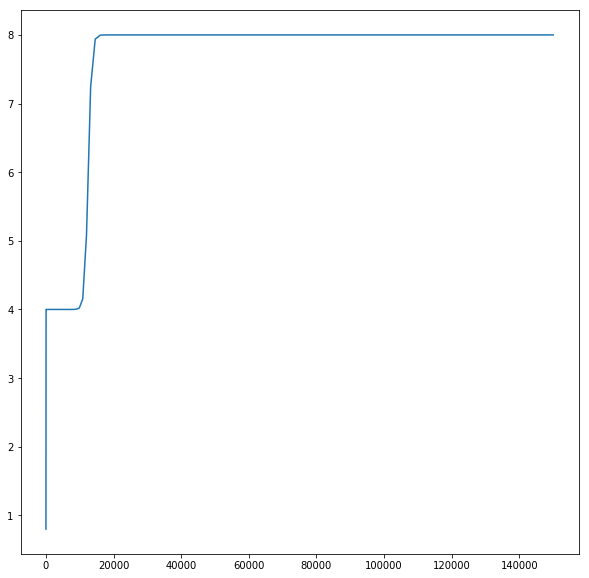

In [8]:
x = np.logspace(1, np.log10(150000.), 100)


y = np.minimum(4.0, 0.08*x) + 4.0/(1.+np.exp(-0.002*(x-12500.)))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x, y)

In [58]:
from scipy.sparse import dia_matrix
A = 0.0002
t = 2.45

ncols = 50

diags = np.asarray([np.ones(ncols)] + [A*np.ones(ncols)*np.exp(-i/t) for i in range(9)])
D = dia_matrix((diags, np.arange(-diags.shape[0]+1, 1)), shape=(ncols, ncols))
print(D)

Dinv = inv(D)
print(np.arange(-diags.shape[0]+1, 1)[::-1])

  (9, 0)	1.0
  (10, 1)	1.0
  (11, 2)	1.0
  (12, 3)	1.0
  (13, 4)	1.0
  (14, 5)	1.0
  (15, 6)	1.0
  (16, 7)	1.0
  (17, 8)	1.0
  (18, 9)	1.0
  (19, 10)	1.0
  (20, 11)	1.0
  (21, 12)	1.0
  (22, 13)	1.0
  (23, 14)	1.0
  (24, 15)	1.0
  (25, 16)	1.0
  (26, 17)	1.0
  (27, 18)	1.0
  (28, 19)	1.0
  (29, 20)	1.0
  (30, 21)	1.0
  (31, 22)	1.0
  (32, 23)	1.0
  (33, 24)	1.0
  :	:
  (25, 25)	7.637048786784323e-06
  (26, 26)	7.637048786784323e-06
  (27, 27)	7.637048786784323e-06
  (28, 28)	7.637048786784323e-06
  (29, 29)	7.637048786784323e-06
  (30, 30)	7.637048786784323e-06
  (31, 31)	7.637048786784323e-06
  (32, 32)	7.637048786784323e-06
  (33, 33)	7.637048786784323e-06
  (34, 34)	7.637048786784323e-06
  (35, 35)	7.637048786784323e-06
  (36, 36)	7.637048786784323e-06
  (37, 37)	7.637048786784323e-06
  (38, 38)	7.637048786784323e-06
  (39, 39)	7.637048786784323e-06
  (40, 40)	7.637048786784323e-06
  (41, 41)	7.637048786784323e-06
  (42, 42)	7.637048786784323e-06
  (43, 43)	7.637048786784323e-06
  (

TypeError: Image data cannot be converted to float

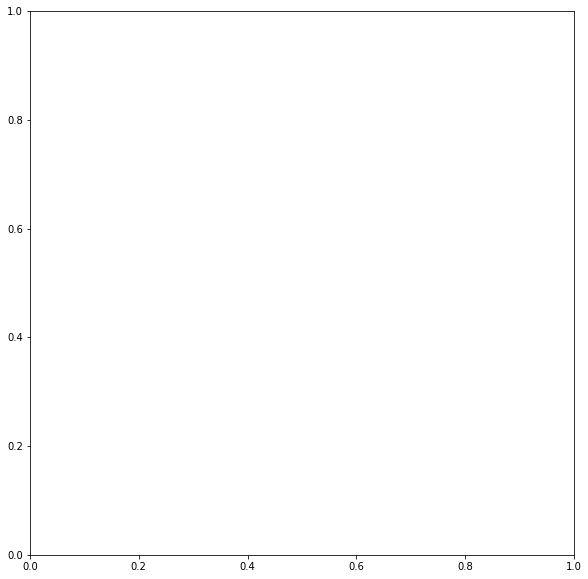

In [47]:
fig, ax =plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(D.toarray)